# 1. Import Libraries

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
import torch
from typing import List, Tuple
from ultralytics import YOLO

# 2. Set Up Configuration

In [4]:
# Paths
INPUT_DIR = "Final/test/input"
OUTPUT_DIR = "Final/test/output"
ANONYMIZED_DIR = "Final/test/anonymized"

# Create directories if they don't exist
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(ANONYMIZED_DIR, exist_ok=True)

# Model paths
FACE_MODEL_PATH = "stage1_face_detection/pii_detection/face_license_detection_phase2/weights/best.pt"  # Your trained face model
PLATE_MODEL_PATH = "Stage1_Anonimizer/best_plate.pt"  # Your trained plate model
MODEL_PATH = "stage2_Classifier/final_model.h5"  # Your urban issues classifier

# Classification categories
SUB_CATEGORIES = [
    'Potholes',
    'Damaged Signs',
    'Fallen Trees',
    'Graffiti', 
    'Garbage',
    'Illegal Parking',
]

MAIN_CATEGORY_MAP = {
    'Potholes': 'Road Issues',
    'Damaged Signs': 'Public Safety',
    'Fallen Trees': 'Public Safety',
    'Graffiti': 'Public Cleanliness',
    'Garbage': 'Public Cleanliness',
    'Illegal Parking': 'Road Issues',
}

# Model confidence thresholds
DETECTION_THRESHOLD = 0.25  # For PII detection
CLASSIFICATION_THRESHOLD = 0.4  # For urban issue classification

# 3. Define Anonymization Functions

In [5]:
def clamp_box(x1, y1, x2, y2, w, h):
    """Ensure box coordinates stay within image boundaries"""
    return max(0, x1), max(0, y1), min(w - 1, x2), min(h - 1, y2)

def expand_box(x1, y1, x2, y2, w, h, margin=0.1):
    """Expand bounding box by a margin percentage"""
    bw, bh = (x2 - x1), (y2 - y1)
    mx, my = int(bw * margin), int(bh * margin)
    return clamp_box(x1 - mx, y1 - my, x2 + mx, y2 + my, w, h)

def blur_region(img, box, ksize=21):
    """Apply Gaussian blur to a specific region"""
    x1, y1, x2, y2 = box
    roi = img[y1:y2, x1:x2]
    if roi.size == 0:
        return img
    ksize = int(ksize) | 1  # make odd
    img[y1:y2, x1:x2] = cv2.GaussianBlur(roi, (ksize, ksize), 0)
    return img

def pixelate_region(img, box, downscale=12):
    """Apply pixelation to a specific region"""
    x1, y1, x2, y2 = box
    roi = img[y1:y2, x1:x2]
    if roi.size == 0:
        return img
    h, w = roi.shape[:2]
    small = cv2.resize(roi, (max(1, w // downscale), max(1, h // downscale)), 
                      interpolation=cv2.INTER_LINEAR)
    pixelated = cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
    img[y1:y2, x1:x2] = pixelated
    return img

def redact(img, boxes, mode="blur", margin=0.1, blur_ksize=21, pixel_downscale=12):
    """Apply redaction (blur or pixelation) to detected regions"""
    H, W = img.shape[:2]
    out = img.copy()
    for (x1, y1, x2, y2, _) in boxes:
        X1, Y1, X2, Y2 = expand_box(x1, y1, x2, y2, W, H, margin)
        if mode == "blur":
            out = blur_region(out, (X1, Y1, X2, Y2), ksize=blur_ksize)
        else:
            out = pixelate_region(out, (X1, Y1, X2, Y2), downscale=pixel_downscale)
    return out

# 4. Define PII Detection and Anonymization Function

In [6]:
def detect_and_anonymize(image_path, output_path=None, 
                         face_model_path=FACE_MODEL_PATH,
                         plate_model_path=PLATE_MODEL_PATH, 
                         face_conf=0.25, face_mode="blur", face_margin=0.1,
                         plate_conf=0.2, plate_mode="pixelate", plate_margin=0.15):
    """Detect and anonymize faces and license plates in an image using separate models"""
    
    # Check if models exist
    if not os.path.exists(face_model_path):
        raise FileNotFoundError(f"Face model not found at {face_model_path}")
        
    if not os.path.exists(plate_model_path):
        raise FileNotFoundError(f"Plate model not found at {plate_model_path}")
    
    # Load models
    face_model = YOLO(face_model_path)
    plate_model = YOLO(plate_model_path)
    
    # Read image
    img = cv2.imread(str(image_path))
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")
    
    # Process image copy
    result_img = img.copy()
    
    # Step 1: Detect and anonymize faces
    faces = []
    face_results = face_model(img, conf=face_conf)
    
    if len(face_results) > 0 and hasattr(face_results[0], "boxes"):
        for box in face_results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls_id = int(box.cls[0])
            
            # For face model, we only consider class 0 (face)
            if conf >= face_conf and (cls_id == 0):  # Typically face is class 0
                faces.append((x1, y1, x2, y2, conf))
    
    # Step 2: Detect and anonymize license plates with dedicated model
    plates = []
    plate_results = plate_model(img, conf=plate_conf)
    
    if len(plate_results) > 0 and hasattr(plate_results[0], "boxes"):
        for box in plate_results[0].boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            
            # For dedicated plate model, all detections are considered plates
            # If the model has multiple classes, you may need to filter by cls_id
            plates.append((x1, y1, x2, y2, conf))
    
    # Apply anonymization
    
    # Anonymize faces
    if faces:
        result_img = redact(result_img, faces, mode=face_mode, margin=face_margin)
    
    # Anonymize license plates
    if plates:
        result_img = redact(result_img, plates, mode=plate_mode, margin=plate_margin)
    
    # Save output if path provided
    if output_path:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        cv2.imwrite(output_path, result_img)
    
    return {
        "original_img": img,
        "anonymized_img": result_img,
        "faces_detected": len(faces),
        "plates_detected": len(plates),
        "face_boxes": faces,
        "plate_boxes": plates
    }

# 5. Define Urban Issue Classification Function

In [7]:
def classify_urban_issues(image_path, model_path=MODEL_PATH, threshold=CLASSIFICATION_THRESHOLD):
    """Classify urban issues in an image"""
    
    # Load trained model
    model = load_model(model_path)
    
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predict
    preds = model.predict(img_array)[0]
    
    # Get predictions above threshold
    detected_classes = []
    for i, conf in enumerate(preds):
        if conf >= threshold:
            sub_category = SUB_CATEGORIES[i]
            main_category = MAIN_CATEGORY_MAP[sub_category]
            detected_classes.append({
                'sub_category': sub_category,
                'main_category': main_category,
                'confidence': float(conf)
            })
    
    # Sort by confidence
    detected_classes = sorted(detected_classes, key=lambda x: x['confidence'], reverse=True)
    
    return {
        'predictions': detected_classes,
        'raw_scores': preds,
        'threshold': threshold
    }

# 6. Complete End-to-End Pipeline

In [8]:
def process_image(image_name, input_dir=INPUT_DIR, anonymized_dir=ANONYMIZED_DIR, output_dir=OUTPUT_DIR):
    """Complete pipeline to process a single image"""
    
    # Construct paths
    image_path = os.path.join(input_dir, image_name)
    anonymized_path = os.path.join(anonymized_dir, f"anonymized_{image_name}")
    
    print(f"Processing image: {image_name}")
    
    # Step 1: Detect and anonymize PII
    print("\nStep 1: Anonymizing faces and license plates...")
    anon_result = detect_and_anonymize(image_path, anonymized_path)
    
    print(f"  Faces detected: {anon_result['faces_detected']}")
    print(f"  License plates detected: {anon_result['plates_detected']}")
    
    # Step 2: Classify urban issues
    print("\nStep 2: Classifying urban issues...")
    classification = classify_urban_issues(anonymized_path)
    
    # Display results
    print("\n=== Results ===")
    if classification['predictions']:
        print("\nDetected urban issues:")
        for i, pred in enumerate(classification['predictions']):
            print(f"  {i+1}. {pred['sub_category']} ({pred['main_category']}) - Confidence: {pred['confidence']:.2f}")
    else:
        print("No urban issues detected with confidence above threshold.")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original image
    axes[0].imshow(cv2.cvtColor(anon_result['original_img'], cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Anonymized image
    axes[1].imshow(cv2.cvtColor(anon_result['anonymized_img'], cv2.COLOR_BGR2RGB))
    axes[1].set_title("Anonymized Image")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"comparison_{image_name}"))
    plt.show()
    
    # Plot confidence scores
    plt.figure(figsize=(10, 6))
    scores = classification['raw_scores']
    plt.bar(SUB_CATEGORIES, scores, color='skyblue')
    plt.axhline(y=classification['threshold'], color='r', linestyle='-', label=f'Threshold ({classification["threshold"]})')
    plt.xlabel('Urban Issue Categories')
    plt.ylabel('Confidence Score')
    plt.title('Classification Confidence Scores')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"scores_{image_name}"))
    plt.show()
    
    return {
        'anonymization': anon_result,
        'classification': classification
    }

# 7. Run the Pipeline on Test Images

Found 2 images in the input folder
Processing image: image1.png

Step 1: Anonymizing faces and license plates...

0: 448x640 (no detections), 1255.4ms
Speed: 9.4ms preprocess, 1255.4ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 134.4ms
Speed: 2.7ms preprocess, 134.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
  Faces detected: 0
  License plates detected: 0

Step 2: Classifying urban issues...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step

=== Results ===

Detected urban issues:
  1. Potholes (Road Issues) - Confidence: 0.96


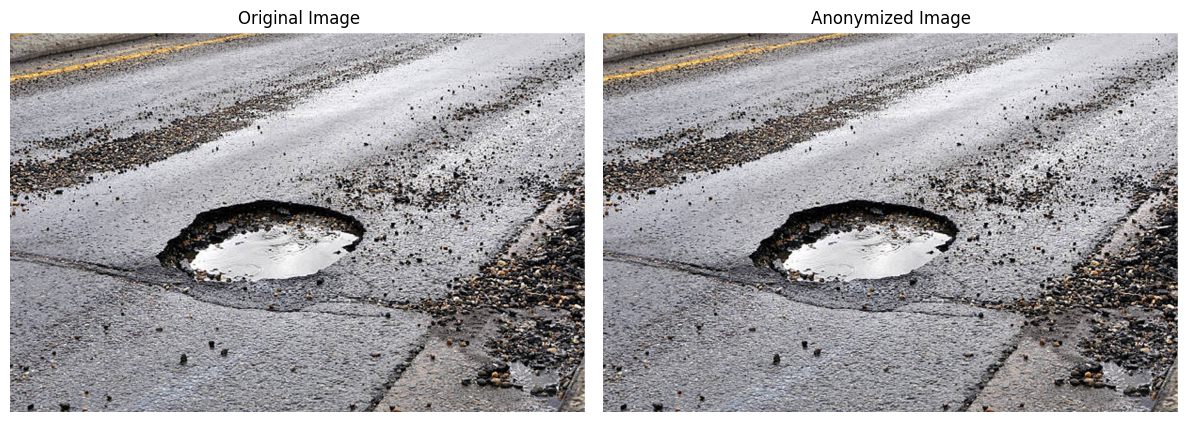

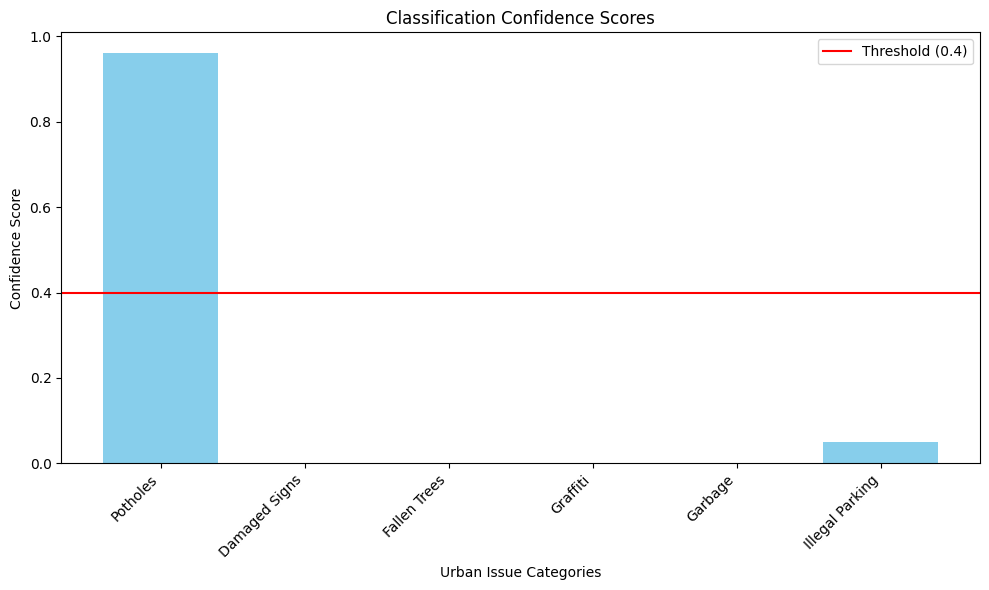


=== Processing Complete ===
Image: image1.png
Faces anonymized: 0
License plates anonymized: 0
Urban issues detected: 1

Results saved in: Final/test/output


In [10]:
# List images in the input folder
input_images = os.listdir(INPUT_DIR)

if not input_images:
    print("No images found in the input folder. Please add images to Final/test/input/")
else:
    print(f"Found {len(input_images)} images in the input folder")
    
    # Process first image as an example
    if len(input_images) > 0:
        example_image = input_images[0]
        results = process_image(example_image)
        
        # Summary
        print("\n=== Processing Complete ===")
        print(f"Image: {example_image}")
        print(f"Faces anonymized: {results['anonymization']['faces_detected']}")
        print(f"License plates anonymized: {results['anonymization']['plates_detected']}")
        print(f"Urban issues detected: {len(results['classification']['predictions'])}")
        print("\nResults saved in:", OUTPUT_DIR)

# 8. Batch Processing Function 

Processing 2 images...

--- Processing image1.png ---
Processing image: image1.png

Step 1: Anonymizing faces and license plates...

0: 448x640 (no detections), 549.4ms
Speed: 5.1ms preprocess, 549.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 448x640 (no detections), 127.3ms
Speed: 4.3ms preprocess, 127.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
  Faces detected: 0
  License plates detected: 0

Step 2: Classifying urban issues...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step

=== Results ===

Detected urban issues:
  1. Potholes (Road Issues) - Confidence: 0.96


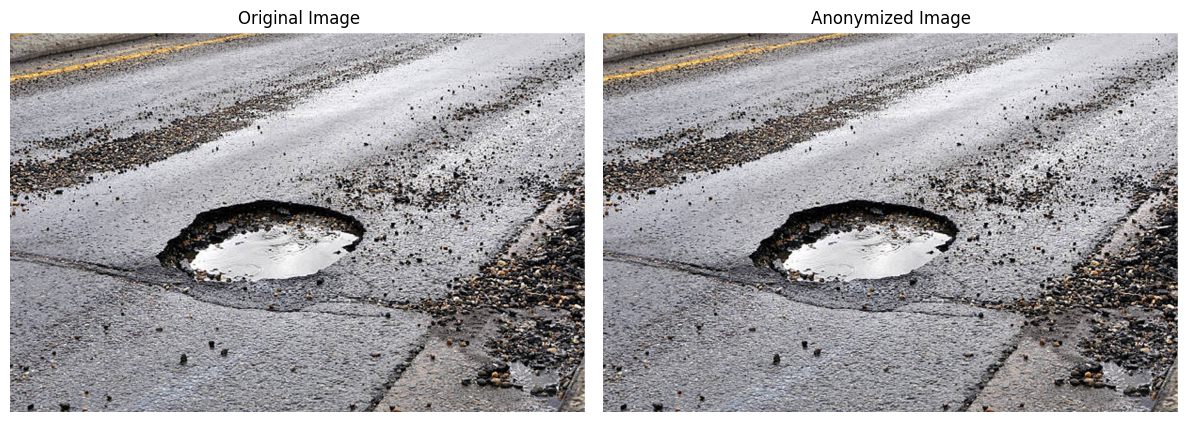

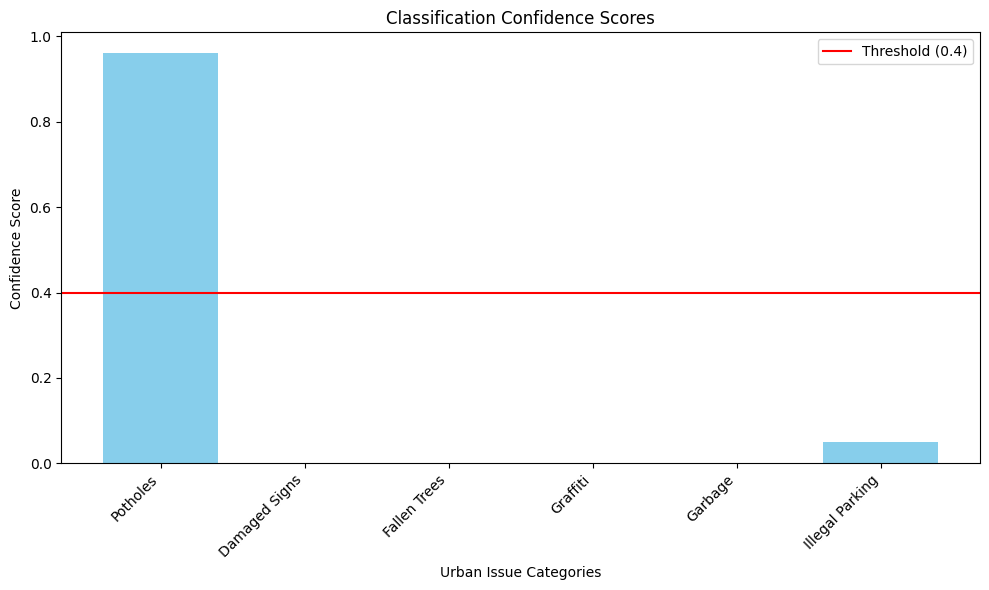


--- Processing image2.png ---
Processing image: image2.png

Step 1: Anonymizing faces and license plates...

0: 384x640 2 License_Plates, 769.7ms
Speed: 4.1ms preprocess, 769.7ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 140.1ms
Speed: 4.3ms preprocess, 140.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
  Faces detected: 2
  License plates detected: 0

Step 2: Classifying urban issues...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step

=== Results ===

Detected urban issues:
  1. Fallen Trees (Public Safety) - Confidence: 0.65


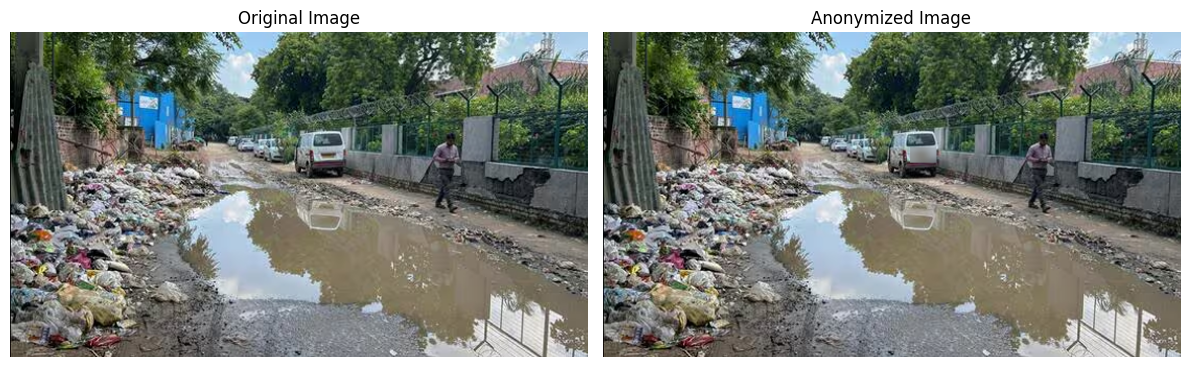

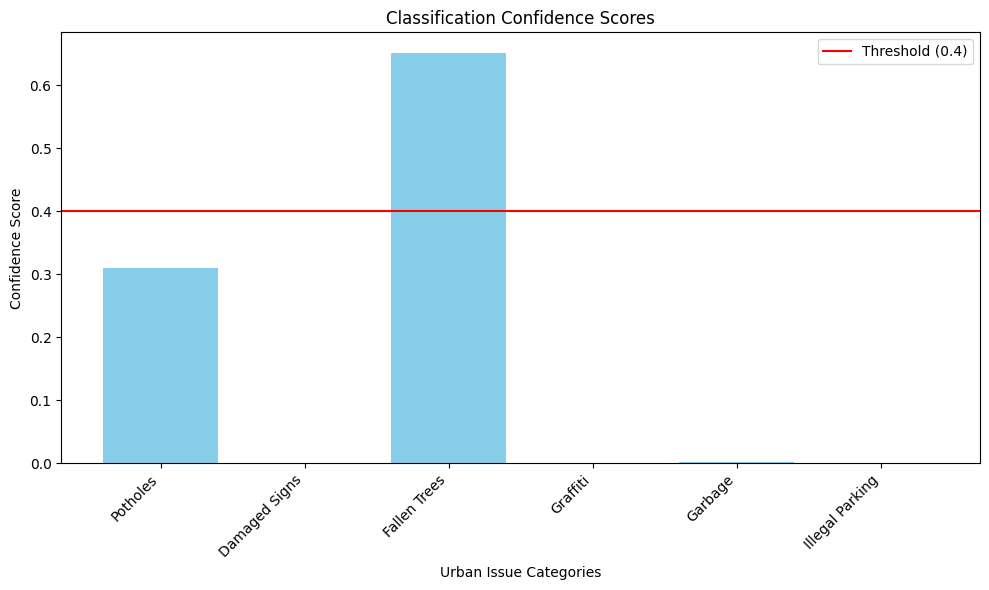


=== Processing Summary ===
Image                | Faces  | Plates | Issues
---------------------------------------------
image1.png           | 0      | 0      | 1     
image2.png           | 2      | 0      | 1     


In [13]:
def batch_process(input_dir=INPUT_DIR, anonymized_dir=ANONYMIZED_DIR, output_dir=OUTPUT_DIR):
    """Process all images in the input directory"""
    
    input_images = [f for f in os.listdir(input_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not input_images:
        print("No images found in the input folder.")
        return
    
    print(f"Processing {len(input_images)} images...")
    
    results = []
    for img_name in input_images:
        try:
            print(f"\n--- Processing {img_name} ---")
            result = process_image(img_name, input_dir, anonymized_dir, output_dir)
            results.append({
                'image': img_name,
                'faces': result['anonymization']['faces_detected'],
                'plates': result['anonymization']['plates_detected'],
                'urban_issues': len(result['classification']['predictions'])
            })
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    
    # Create summary table
    print("\n=== Processing Summary ===")
    print(f"{'Image':<20} | {'Faces':<6} | {'Plates':<6} | {'Issues':<6}")
    print("-" * 45)
    
    for r in results:
        print(f"{r['image']:<20} | {r['faces']:<6} | {r['plates']:<6} | {r['urban_issues']:<6}")
        
    return results

# Uncomment to run batch processing
batch_results = batch_process()